In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from utils.matrix_builder import create_expanded_feature_matrix, create_feature_matrix
from itertools import product

import warnings
warnings.filterwarnings("ignore")

# Debug parameter
DEBUG = True

if DEBUG:
    print("Debug mode is ON. Detailed output will be printed.")

# Load Database
csv_hour_file = '../data/ta_metrics/final_price_ta_metrics.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

# Define the Sliding Windows for this run
sliding_window = 10 # of days to train on (matrix rows)
lag_price_window = 3  # Window of the number of previous days as features (matrix columns)

training_sliding_window = sliding_window + 1  # +1 to include the next row as the test set

# Calculate number of sliding window models to train in the dataset
num_sliding_windows = len(df) - training_sliding_window
if DEBUG:
    print(f"Number of rows in the dataset: {len(df)}")

print(f"Number of sliding windows to train: {num_sliding_windows}")

# Random Forest hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create all combinations of parameters
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'], 
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['max_features']
))

print(f"Total parameter combinations to test: {len(param_combinations)}")

# Initialize lists to store results
predictions_list = []
actuals_list = []
timestamps_list = []
best_params_list = []  # Store best parameters for each window

for i in range(num_sliding_windows):
    if DEBUG:
        print(f"Processing sliding window {i + 1}/{num_sliding_windows}...")

    # Ensure we do not exceed the DataFrame length
    if i + training_sliding_window >= len(df):
        break  # Avoid index out of bounds
    
    sliding_window_set = df.iloc[i : i + training_sliding_window]
    
    # Create feature matrix and target variable for training
    X_train, y_train = create_expanded_feature_matrix(sliding_window_set, lag_price_window)
    
    # Split for training and prediction
    X_train_fit = X_train.iloc[:-1]
    y_train_fit = y_train.iloc[:-1]

    X_to_predict = X_train.iloc[-1:]
    y_to_predict = y_train.iloc[-1]

    # Optional: Scale features (Random Forest doesn't require scaling, but can help)
    
    lowest_mae = float('inf')
    best_params = None
    y_predicted = None

    # Test each parameter combination
    for j, params in enumerate(param_combinations):
        n_est, max_d, min_split, min_leaf, max_feat = params
        
        # Create and train Random Forest model
        rf_model = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=max_d,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            max_features=max_feat,
            random_state=42,
            n_jobs=-1  # Use all available cores
        )
        
        # Train on scaled data (you can also use unscaled data for RF)
        rf_model.fit(X_train_fit, y_train_fit)
        rf_prediction = rf_model.predict(X_to_predict)

        # Add bounds checking to catch extreme predictions
        if rf_prediction[0] < 0:
            rf_prediction[0] = 0

        if abs(rf_prediction[0]) > 1000:  # Reasonable price bounds
            continue  # Skip this parameter set if prediction is unrealistic
    
        # Calculate the mean absolute error
        mae = mean_absolute_error([y_to_predict], rf_prediction)

        if DEBUG:
            print(f"Params {j+1}/{len(param_combinations)}: n_est={n_est}, max_depth={max_d}, "
                  f"min_split={min_split}, min_leaf={min_leaf}, max_feat={max_feat}, MAE: {mae}")
            
        if mae < lowest_mae:
            lowest_mae = mae
            best_params = params
            y_predicted = rf_prediction

            if DEBUG:
                print(f"New best params found with MAE: {lowest_mae}")
            
    # Store best parameters for this window
    best_params_list.append(best_params)

    if DEBUG:
        print(f"Best params for sliding window {i}: {best_params} with MAE: {lowest_mae}")
    
    # Store results
    predictions_list.append(y_predicted[0])
    actuals_list.append(y_to_predict)
    if 'Datetime' in sliding_window_set.columns:
        timestamps_list.append(sliding_window_set.iloc[-1]['Datetime'])
    else:
        timestamps_list.append(i + training_sliding_window - 1)

# Create final prediction DataFrame
prediction_df = pd.DataFrame({
    'Timestamp': timestamps_list,
    'Predicted': predictions_list,
    'Actual': actuals_list
})

# Calculate overall metrics
mse = mean_squared_error(actuals_list, predictions_list)
mae = mean_absolute_error(actuals_list, predictions_list)
r2 = r2_score(actuals_list, predictions_list)

print(f"Overall Mean Squared Error: {mse}")
print(f"Overall Mean Absolute Error: {mae}")
print(f"Overall R^2 Score: {r2}")

# Analyze most common best parameters
best_params_df = pd.DataFrame(best_params_list, columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features'])

print("\nMost common parameter values:")
for param in best_params_df.columns:
    most_common = best_params_df[param].mode()[0]
    print(f"Best {param}: {most_common}")

# Show parameter distribution
print(f"\nParameter distribution across all windows:")
print(best_params_df.describe())

Debug mode is ON. Detailed output will be printed.
Number of rows in the dataset: 2260
Number of sliding windows to train: 2249
Total parameter combinations to test: 324
Processing sliding window 1/2249...
Params 1/324: n_est=50, max_depth=3, min_split=2, min_leaf=1, max_feat=sqrt, MAE: 1.4054000000000286
New best params found with MAE: 1.4054000000000286
Params 2/324: n_est=50, max_depth=3, min_split=2, min_leaf=1, max_feat=log2, MAE: 1.4054000000000286
Params 3/324: n_est=50, max_depth=3, min_split=2, min_leaf=1, max_feat=None, MAE: 1.4032000000000409
New best params found with MAE: 1.4032000000000409
Params 4/324: n_est=50, max_depth=3, min_split=2, min_leaf=2, max_feat=sqrt, MAE: 1.4936833333333368
Params 5/324: n_est=50, max_depth=3, min_split=2, min_leaf=2, max_feat=log2, MAE: 1.4936833333333368
Params 6/324: n_est=50, max_depth=3, min_split=2, min_leaf=2, max_feat=None, MAE: 1.6394833333333452
Params 7/324: n_est=50, max_depth=3, min_split=2, min_leaf=4, max_feat=sqrt, MAE: 1.77

KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from utils.matrix_builder import create_ta_feature_matrix, create_feature_matrix
from itertools import product

import warnings
warnings.filterwarnings("ignore")

# Debug parameter
DEBUG = True

if DEBUG:
    print("Debug mode is ON. Detailed output will be printed.")

# Load Database
csv_hour_file = '../data/ta_metrics/final_price_ta_metrics.csv'
df = pd.read_csv(csv_hour_file, parse_dates=['Datetime'])

# Define the Sliding Windows for this run
sliding_window = 10 # of days to train on (matrix rows)
lag_price_window = 3  # Window of the number of previous days as features (matrix columns)

training_sliding_window = sliding_window + 1  # +1 to include the next row as the test set

# Calculate number of sliding window models to train in the dataset
num_sliding_windows = len(df) - training_sliding_window
if DEBUG:
    print(f"Number of rows in the dataset: {len(df)}")

print(f"Number of sliding windows to train: {num_sliding_windows}")

# Simplified Random Forest hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None]
}

# Create all combinations of parameters
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth']
))

print(f"Total parameter combinations to test: {len(param_combinations)}")

# Initialize lists to store results
predictions_list = []
actuals_list = []
timestamps_list = []
best_params_list = []  # Store best parameters for each window

for i in range(num_sliding_windows):
    if DEBUG:
        print(f"Processing sliding window {i + 1}/{num_sliding_windows}...")

    # Ensure we do not exceed the DataFrame length
    if i + training_sliding_window >= len(df):
        break  # Avoid index out of bounds
    
    sliding_window_set = df.iloc[i : i + training_sliding_window]
    
    # Create feature matrix and target variable for training
    X_train, y_train = create_ta_feature_matrix(sliding_window_set, lag_price_window)
    
    # Split for training and prediction
    X_train_fit = X_train.iloc[:-1]
    y_train_fit = y_train.iloc[:-1]

    X_to_predict = X_train.iloc[-1:]
    y_to_predict = y_train.iloc[-1]

    # Optional: Scale features (Random Forest doesn't require scaling, but can help)
    
    lowest_mae = float('inf')
    best_params = None
    y_predicted = None

    # Test each parameter combination
    for j, params in enumerate(param_combinations):
        n_est, max_d = params
        
        # Create and train Random Forest model
        rf_model = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=max_d,
            random_state=42,
            n_jobs=-1  # Use all available cores
        )
        
        # Train the model
        rf_model.fit(X_train_fit, y_train_fit)
        rf_prediction = rf_model.predict(X_to_predict)

        # Add bounds checking to catch extreme predictions
        if rf_prediction[0] < 0:
            rf_prediction[0] = 0

        if abs(rf_prediction[0]) > 1000:  # Reasonable price bounds
            continue  # Skip this parameter set if prediction is unrealistic
    
        # Calculate the mean absolute error
        mae = mean_absolute_error([y_to_predict], rf_prediction)

        if DEBUG:
            print(f"Params {j+1}/{len(param_combinations)}: n_estimators={n_est}, max_depth={max_d}, MAE: {mae}")
            
        if mae < lowest_mae:
            lowest_mae = mae
            best_params = params
            y_predicted = rf_prediction

            if DEBUG:
                print(f"New best params found with MAE: {lowest_mae}")
            
    # Store best parameters for this window
    best_params_list.append(best_params)

    if DEBUG:
        print(f"Best params for sliding window {i}: {best_params} with MAE: {lowest_mae}")
    
    # Store results
    predictions_list.append(y_predicted[0])
    actuals_list.append(y_to_predict)
    if 'Datetime' in sliding_window_set.columns:
        timestamps_list.append(sliding_window_set.iloc[-1]['Datetime'])
    else:
        timestamps_list.append(i + training_sliding_window - 1)

# Create final prediction DataFrame
prediction_df = pd.DataFrame({
    'Timestamp': timestamps_list,
    'Predicted': predictions_list,
    'Actual': actuals_list
})

# Calculate overall metrics
mse = mean_squared_error(actuals_list, predictions_list)
mae = mean_absolute_error(actuals_list, predictions_list)
r2 = r2_score(actuals_list, predictions_list)

print(f"Overall Mean Squared Error: {mse}")
print(f"Overall Mean Absolute Error: {mae}")
print(f"Overall R^2 Score: {r2}")

# Analyze most common best parameters
best_params_df = pd.DataFrame(best_params_list, columns=['n_estimators', 'max_depth'])

print("\nMost common parameter values:")
for param in best_params_df.columns:
    most_common = best_params_df[param].mode()[0]
    print(f"Best {param}: {most_common}")

# Show parameter distribution
print(f"\nParameter distribution across all windows:")
print(best_params_df.describe())

Debug mode is ON. Detailed output will be printed.
Number of rows in the dataset: 2260
Number of sliding windows to train: 2249
Total parameter combinations to test: 12
Processing sliding window 1/2249...
Params 1/12: n_estimators=50, max_depth=3, MAE: 1.4032000000000409
New best params found with MAE: 1.4032000000000409
Params 2/12: n_estimators=50, max_depth=5, MAE: 1.4030000000000342
New best params found with MAE: 1.4030000000000342
Params 3/12: n_estimators=50, max_depth=10, MAE: 1.4030000000000342
Params 4/12: n_estimators=50, max_depth=None, MAE: 1.4030000000000342
Params 5/12: n_estimators=100, max_depth=3, MAE: 1.4064000000000902
Params 6/12: n_estimators=100, max_depth=5, MAE: 1.406300000000094
Params 7/12: n_estimators=100, max_depth=10, MAE: 1.406300000000094
Params 8/12: n_estimators=100, max_depth=None, MAE: 1.406300000000094
Params 9/12: n_estimators=200, max_depth=3, MAE: 1.4160000000001105
Params 10/12: n_estimators=200, max_depth=5, MAE: 1.4159500000001088
Params 11/1

ModuleNotFoundError: No module named 'seaborn'

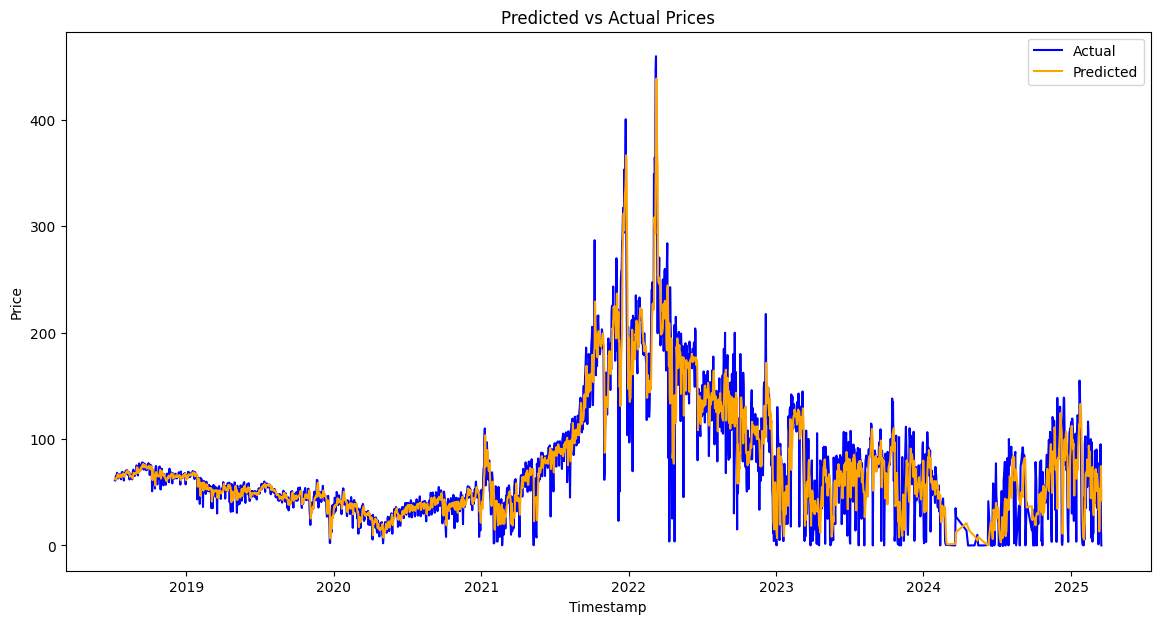

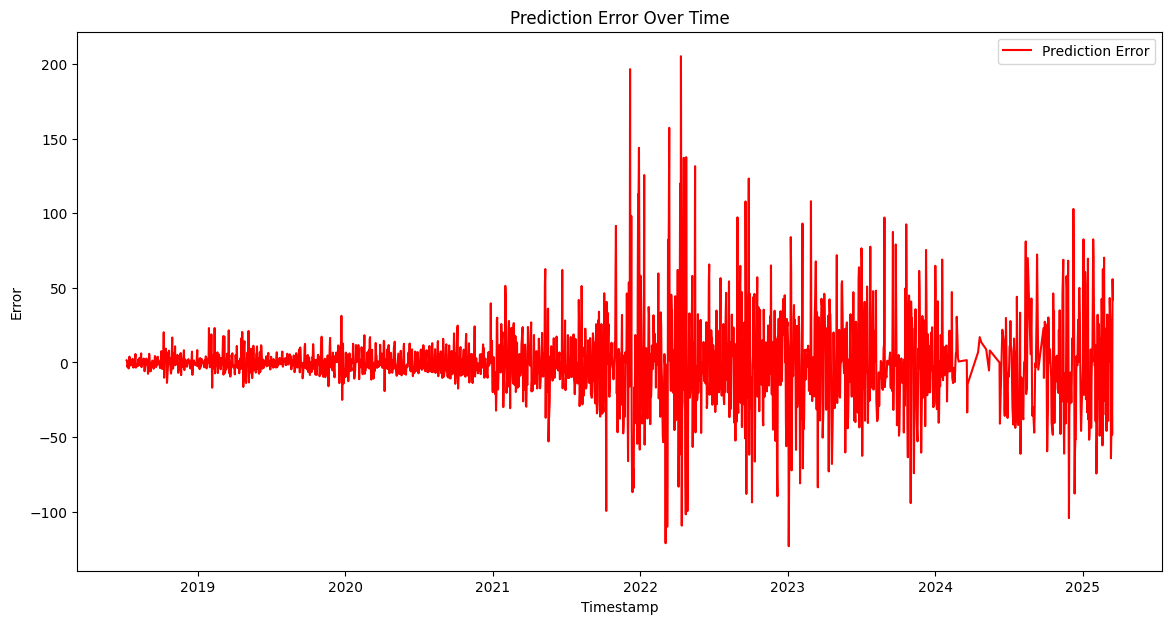

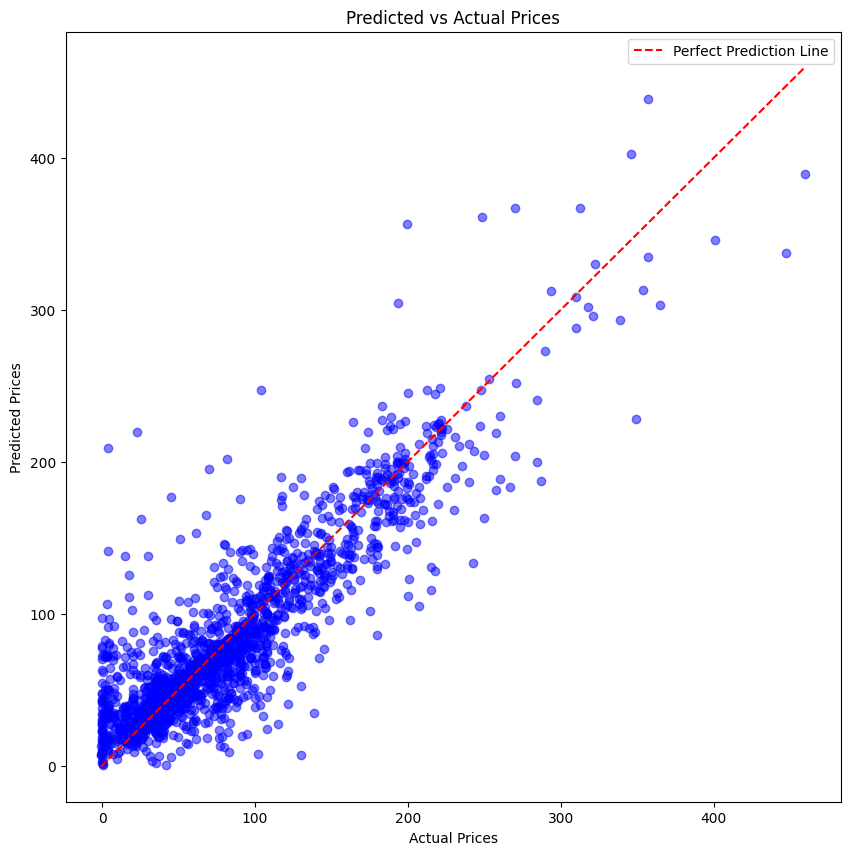

<Figure size 1200x600 with 0 Axes>

In [8]:
# Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(prediction_df['Timestamp'], prediction_df['Actual'], label='Actual', color='blue')
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted'], label='Predicted', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices')
plt.legend()

# Plot error metrics
plt.figure(figsize=(14, 7))
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted'] - prediction_df['Actual'], label='Prediction Error', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Error')
plt.title('Prediction Error Over Time')
plt.legend()

# Plot a scatter plot of predicted vs actual prices with the intercept line
plt.figure(figsize=(10, 10))
plt.scatter(prediction_df['Actual'], prediction_df['Predicted'], alpha=0.5, color='blue')
plt.plot([prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         [prediction_df['Actual'].min(), prediction_df['Actual'].max()],
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.legend()

# plot distribution of random forest parameters
plt.figure(figsize=(12, 6))
import seaborn as sns
sns.countplot(data=best_params_df, x='n_estimators', hue='max_depth')
plt.title('Distribution of Random Forest Parameters')
plt.xlabel('Number of Estimators')
plt.ylabel('Count')
plt.legend(title='Max Depth')
plt.tight_layout()
plt.show()
